In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pprint
import copy
import matplotlib.pyplot as plt
import itertools

# Load vocab and training dataset

In [25]:
# Load and treat vocab
with open('vocab.txt') as file:
    vocab = file.readlines()
    vocab = [line.rstrip() for line in vocab]

vocab_size = len(vocab)
print('There are %d unique words in our dataset.' % vocab_size)

# Hash table for words to indices and viceversa
word_to_ix = { w:i for i,w in enumerate(vocab) }
ix_to_word = { i:w for i,w in enumerate(vocab) }

There are 20500 unique words in our dataset.


In [26]:
vocab

['',
 '00',
 '0000',
 '000000',
 '001',
 '004',
 '008',
 '01',
 '010',
 '01087',
 '011',
 '012',
 '016',
 '01745',
 '01918',
 '02',
 '020',
 '0201',
 '0208',
 '03',
 '032',
 '04',
 '040',
 '05',
 '052',
 '055',
 '056',
 '057',
 '06',
 '07',
 '0710',
 '0725',
 '08',
 '080',
 '081',
 '09',
 '10',
 '100',
 '1000',
 '10000',
 '10006',
 '10007',
 '10029',
 '10079',
 '10081',
 '101',
 '1010',
 '102',
 '1024',
 '103',
 '1035',
 '104',
 '105',
 '106',
 '107',
 '108',
 '1082',
 '109',
 '11',
 '110',
 '1100',
 '111',
 '1110',
 '112',
 '1123',
 '113',
 '114',
 '115',
 '116',
 '117',
 '1179',
 '118',
 '119',
 '12',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '1250',
 '1251',
 '1252',
 '126',
 '127',
 '128',
 '1282',
 '1284',
 '1285',
 '1288',
 '1291',
 '1296',
 '13',
 '1301',
 '1304',
 '1305',
 '1307',
 '131',
 '1311',
 '1314',
 '1317',
 '132',
 '1320',
 '133',
 '134',
 '137',
 '1370',
 '1377',
 '1394',
 '1395',
 '14',
 '141',
 '142',
 '1423',
 '14443',
 '145',
 '148',
 '1496',
 '15',
 '1500'

In [27]:
# Load training set. 
dfs = pd.read_csv('ordered-labels-dataset-subsample.txt', delim_whitespace=True, index_col = 0, header = None, engine='python') #keep_default_na = False, Keep 'null' as valid value.

# Build set with lists
dfs['Words'] = dfs.dropna()[2].apply(lambda x: x.split('_'))
# Build input for transformer: add space and end of line
dfs['Names'] = dfs.dropna()['Words'].apply(lambda x: str(' ' + ' '.join(x) + ' \n'))
words_lists = list(dfs.loc[:,'Words'])

In [28]:
df_names = dfs['Names'].dropna()

In [29]:
df_names

0
32977             dpkg set prog name \n
32978              get int attribute \n
32979                  finalize test \n
32980                  run psm shell \n
32981      erlang backings tore grow \n
                      ...              
329784                         sr dt \n
329785             chirp client link \n
329786           cgr preview forward \n
329787            game set color num \n
329788            mdns ec dns packet \n
Name: Names, Length: 296744, dtype: object

In [30]:
# Build csv for transformer model
df_names.to_csv('names.csv',index=False)

In [31]:
# Get stats regarding len of names
dfs['Name_length'] = dfs['Words'].dropna().apply(lambda x: len(x))

dfs['Name_length'].describe()

count    296744.000000
mean          3.656994
std           1.577809
min           1.000000
25%           3.000000
50%           3.000000
75%           5.000000
max          17.000000
Name: Name_length, dtype: float64

# Build probability matrix -not used in transformer model, go to Section 3-

In [85]:
# Number of positions observed
Tx = int(max(dfs['Name_length']))
print('Maximum length of names:', Tx)

# Matrix counting word appearances, row for position, columns for each word (among 20500 words)
word_freq = np.zeros((Tx+1,vocab_size), dtype=np.int32)

for i in range(Tx):
    for word_list in words_lists:
        if isinstance(word_list,list) and len(word_list) > i:
            word_freq[i,word_to_ix[word_list[i]] ] += 1

# Last row: sum of appearances of each word
for j in range(vocab_size):
    word_freq[Tx,j] = sum(word_freq[:,j])
            
word_freq

Maximum length of names: 17


array([[ 0, 10,  0, ...,  1,  1,  0],
       [ 0, 54,  0, ...,  0,  0,  1],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0, 71,  3, ...,  1,  1,  2]])

In [86]:
# Words not appearing in training set:
sum(word_freq[Tx,:] == 0)

792

In [87]:
word_freq_normalized = word_freq[:Tx,:].astype(np.float32)

# Normalize
for j in range(vocab_size):
    if sum(word_freq_normalized[:,j]) != 0:
        word_freq_normalized[:,j] /= sum(word_freq_normalized[:Tx,j])

In [88]:
# Summary of obtained matrices
print(np.shape(word_freq))
print(word_freq[:18,:20])

(18, 20500)
[[ 0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 54  0  0  9  0  0  3  0  1  0  3  0  0  0  1  0  3  0  0]
 [ 0  0  2  2  0  1  0  2  0  0  0  0  0  1  1  7  0  0  0  1]
 [ 0  4  1  1  0  0  1  4  2  0  1  0  0  0  0 18  1  0  1  1]
 [ 0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0

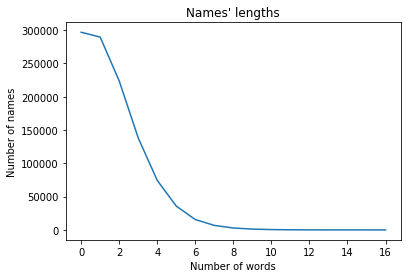

In [89]:
# Plot showing names' length
plt.plot([sum(word_freq[x,:]) for x in range(17)])
plt.title('Names\' lengths')
plt.ylabel('Number of names')
plt.xlabel('Number of words')
plt.show()

# Load GPT2 tokenizer

In [41]:
# Useful links for treating vocab:
# https://discuss.huggingface.co/t/roberta-from-scratch-with-different-vocab-vs-fine-tuning/569
# https://medium.com/@pierre_guillou/nlp-how-to-add-a-domain-specific-vocabulary-new-tokens-to-a-subword-tokenizer-already-trained-33ab15613a41

In [5]:
# Choose DistilGPT2: GPT2 lighter version
model_checkpoint = "distilgpt2"

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) #vocab_file = 'vocab.txt' ??

In [44]:
# should I use the following vocab set ?
# vocab_with_symbol = ['Ġ' + word for word in vocab]

In [45]:
tokenizer.get_vocab()

{'ĠCS': 9429,
 'ĠThumbnails': 28924,
 'ghan': 6064,
 'porting': 26527,
 'ĠLatter': 34437,
 'ĠLore': 15639,
 'ĠTerritories': 42354,
 'Ġpertinent': 35268,
 'Ġtechnology': 3037,
 'Ġcrus': 25164,
 'Ġcalcium': 19700,
 'majority': 35839,
 'ĠEval': 26439,
 'Ġfaux': 36748,
 'Ġagric': 8986,
 'Ġcook': 4255,
 'Ġdefinitive': 17347,
 'Gallery': 29352,
 'Enable': 36695,
 'Ġantidepressant': 41897,
 'ĠEuropeans': 20006,
 'Ġrepent': 28787,
 'Ġsweating': 38912,
 '################': 14468,
 'Ġsmokers': 24109,
 'Ġunamb': 42053,
 'oooo': 13321,
 'ĠErrors': 44225,
 'ĠDresden': 46993,
 '================': 4770,
 'Zip': 41729,
 'Ġacc': 697,
 'lights': 8091,
 'Probably': 34784,
 'ĠUn': 791,
 'ĠObserver': 27058,
 'ĠPreferences': 49780,
 'psons': 31410,
 'Ġunborn': 36172,
 'Ġrain': 6290,
 'Ġmotorcycles': 39404,
 'ĠABV': 49993,
 'akia': 21897,
 'ĠPale': 21706,
 'Ġarsen': 38924,
 'obil': 25898,
 'Ġcontradicts': 40081,
 'Ġexemplary': 40690,
 'Ġnon': 1729,
 'Ġexcept': 2845,
 'Ġhyper': 8718,
 'Ġfucking': 9372,
 'ble'

In [234]:
gpt_vocab = set(tokenizer.get_vocab().keys())

print('GPT2 has a vocab of %d words, the provided vocab has %d words, and there are %d words in their intersection.' 
      %(len(gpt_vocab), len(vocab), len(set(vocab).intersection(gpt_vocab))))

GPT2 has a vocab of 50257 words, the provided vocab has 20500 words, and there are 3871 words in their intersection.


In [270]:
'''# If we wanted to extend the vocabulary:

num_added_toks = tokenizer.add_tokens(vocab)

print('We have added', num_added_toks, 'tokens. New vocab size: ', len(set(tokenizer.get_vocab().keys())))

# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.

model.resize_token_embeddings(len(tokenizer))
'''

"# If we wanted to extend the vocabulary:\n\nnum_added_toks = tokenizer.add_tokens(vocab)\n\nprint('We have added', num_added_toks, 'tokens. New vocab size: ', len(set(tokenizer.get_vocab().keys())))\n\n# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.\n\nmodel.resize_token_embeddings(len(tokenizer))\n"

# Pre process training set

In [49]:
# Load names in a transformer format
import transformers
from datasets import load_dataset
dataset_dict = load_dataset('csv', data_files='names.csv')
dataset = dataset_dict['train']
dataset = dataset.train_test_split(test_size=0.05, shuffle=True, seed=42)

Using custom data configuration default-9d82746b4bd06c73


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to C:\Users\SP003DA2\.cache\huggingface\datasets\csv\default-9d82746b4bd06c73\0.0.0\51cce309a08df9c4d82ffd9363bbe090bf173197fc01a71b034e8594995a1a58. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Names'],
        num_rows: 281906
    })
    test: Dataset({
        features: ['Names'],
        num_rows: 14838
    })
})

In [52]:
def tokenize_function(examples):
    return tokenizer(examples["Names"])

In [53]:
# Tokenize inputs
tokenized_dataset = dataset.map(
    tokenize_function, batched=True, remove_columns=["Names"])

  0%|          | 0/282 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [57]:
# block_size = tokenizer.model_max_length
block_size = 32

In [55]:
# Example of input:
tokenizer.decode(tokenized_dataset["train"][1]['input_ids'])

' handle set global enables \n'

In [58]:
# Concatenate inputs
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Drop the small remainder
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [59]:
lm_dataset = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=1000,
#    num_proc=4,
)

  0%|          | 0/282 [00:00<?, ?ba/s]

  0%|          | 0/15 [00:00<?, ?ba/s]

In [60]:
lm_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 56369
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2957
    })
})

In [61]:
# Inputs changed:
tokenizer.decode(lm_dataset["train"][1]["input_ids"])

' test incremental no break \n rl reap \n check name \n login manager skeleton get controllers \n mcd null able variant equal \n put h'

# Initialize and fine-tune GPT2

In [62]:
from transformers import TFAutoModelForCausalLM

model = TFAutoModelForCausalLM.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [63]:
from transformers import create_optimizer, AdamWeightDecay

In [64]:
optimizer = AdamWeightDecay(lr=2e-5, weight_decay_rate=0.01)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
import tensorflow as tf

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [66]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

train_set = lm_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

test_set = lm_dataset["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

In [67]:
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard

model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-wikitext2"

tensorboard_callback = TensorBoard(log_dir="./clm_model_save/logs")

callbacks = [tensorboard_callback]

model.fit(train_set, validation_data=test_set, epochs=3, callbacks=callbacks)

Epoch 1/3
3524/3524 [==============================] - 13831s 4s/step - loss: 4.3229 - val_loss: 3.9821
Epoch 2/3
3524/3524 [==============================] - 13900s 4s/step - loss: 3.9294 - val_loss: 3.7956
Epoch 3/3
3524/3524 [==============================] - 13650s 4s/step - loss: 3.7740 - val_loss: 3.6951


In [77]:
model.save_pretrained('FineTuned_GPT2_TF')

# Load TF fine tuned model in PyTorch

In [1]:
# Load the model in PyTorch, in order to use 'force_words' functionality
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("./FineTuned_GPT2_TF_v2", from_tf=True) 

All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


# Generate names

In [2]:
# useful links:
# https://discuss.huggingface.co/t/prohibit-gpt-2-from-generating-some-words-on-a-condition/4823
# https://discuss.huggingface.co/t/example-of-prefix-allowed-tokens-fn-while-text-generation/6635
# https://huggingface.co/docs/transformers/v4.20.1/en/main_classes/text_generation#transformers.generation_utils.GenerationMixin.generate
# and look for: prefix_allowed_tokens_fn

In [10]:
len(tokenizer)

50257

In [26]:
def name_from_word_list(word_list):
    
    if not word_list:
        return ''
    
    input_ids = None
    step = 0

    while word_list:

        print('Step ', step)

        force_words_flexible = word_list
        force_words_ids = [ tokenizer(force_words_flexible, add_special_tokens=False).input_ids ]

        outputs = model.generate(
            input_ids = input_ids,
            min_length = 1,
            max_new_tokens = max_len,

            force_words_ids=1,
            num_beams=5,
            num_return_sequences=1,
            no_repeat_ngram_size=1,
            remove_invalid_values=True,
        )
        
        curr_output = tokenizer.decode(outputs[0], skip_special_tokens=True)

        print(max_len, f"Generated: {curr_output}")

        #input_ids = outputs
        input_ids =  tokenizer( tokenizer.decode(outputs[0], skip_special_tokens=True) + ' ', return_tensors = 'pt').input_ids
        word_list.remove( tokenizer.decode(outputs[0], skip_special_tokens=True).split()[step] )

        step += 1
    
    
    final_output = '_'.join( curr_output.split() )
    
    return final_output

In [27]:
word_list = ['crypt', 'block', 'check']
name = name_from_word_list(word_list)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Step  0
1 Generated: block
Step  1
1 Generated: block crypt
Step  2
1 Generated: block crypt check


In [15]:
print('The obtained name is', name)

The obtained name is block_crypt_check


# Read CSV file for testing

In [28]:
import csv

with open("test_file.csv") as fp:
    reader = csv.reader(fp, skipinitialspace=True, delimiter=",", quotechar='"')
    data_read = [row for row in reader]

print(data_read)

[['network', 'open', 'connection'], ['set', 'state', 'trace', 'event', 'dynamic'], ['redo', 'call']]


In [29]:
names_list = []
for word_list in data_read:
    name = name_from_word_list(word_list)
    names_list.append(name)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Step  0
1 Generated: open
Step  1
1 Generated: open network
Step  2
1 Generated: open network connection
Step  0


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


2 Generated: 
set
Step  1
2 Generated: 
set xtstate


ValueError: list.remove(x): x not in list

In [21]:
tokenizer.tokenize('crypt block')

['crypt', 'Ġblock']

In [269]:
for name in names_list:
    print('The obtained name is', name)

The obtained name is open_network_connection
The obtained name is set_state_check_event_trace
The obtained name is call_redo
